In [1]:
#Import necessary packages:
import pandas as pd
import numpy as np
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
from scipy.sparse import csr_matrix

In [2]:
#Loading .csv file to Pandas dataframe
df= pd.read_csv('reviews.csv')

In [3]:
#Protecting original data for future requirements
data= pd.read_csv('reviews.csv')

In [4]:
#Exploring the data information:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551682 entries, 0 to 551681
Data columns (total 2 columns):
overall       551682 non-null float64
reviewText    551466 non-null object
dtypes: float64(1), object(1)
memory usage: 8.4+ MB


In [5]:
#Exploring the data
df.head()

,overall,reviewText
0,5.0,My daughter wanted this book and the price on ...
1,5.0,I bought this zoku quick pop for my daughterr ...
2,4.0,There is no shortage of pop recipes available ...
3,5.0,This book is a must have if you get a Zoku (wh...
4,4.0,This cookbook is great. I have really enjoyed...


In [6]:
#Number of missing values in reviews
len(df[df['reviewText'].isnull()==True])

216

In [7]:
#Dropping the NaN's in reviews column
df=df.dropna(subset=['reviewText'])

In [8]:
#Adding length column to the dataset
df['review_length']= df['reviewText'].apply(len)

## Visualization of data

(0, 5000)

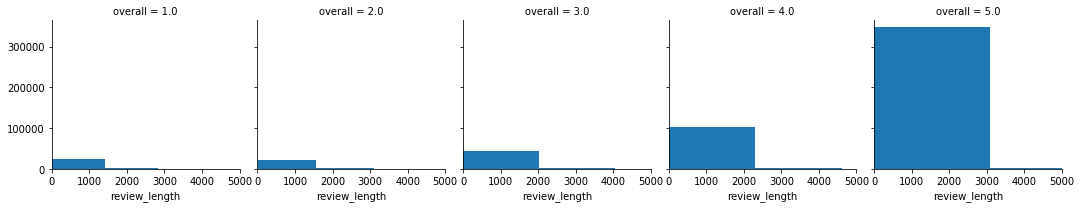

In [9]:
#Histogram grid plot
g = sns.FacetGrid(data=df, col='overall')
g.map(plt.hist, 'review_length')
plt.xlim(0,5000)

In [10]:
#Value counts of the overall rating
df['overall'].value_counts()

5.0    349572
4.0    105477
3.0     45043
1.0     27076
2.0     24298
Name: overall, dtype: int64

## Preprocessing the text

In [11]:
#Converting all the text to lowercase
df['reviewText']= df['reviewText'].str.lower()

In [12]:
# Str replace all non-alphanumeric whitespace
df["reviewText"] = df["reviewText"].str.replace('[^\w\s]','')

In [13]:
#Removing all the numeric values in the text
df["reviewText"] = df["reviewText"].str.replace('\d+', '')

In [14]:
#Tokenizing the text
df["reviewText"] = df["reviewText"].apply(word_tokenize) 

In [15]:
#Function to remove stops words
stop = stopwords.words('english')
def remove_stopwords(tokens):
    return([token for token in tokens if token not in stop])

In [16]:
#Applying function to remove stop words
df["reviewText"] = df["reviewText"].apply(lambda x: remove_stopwords(x)) 

In [17]:
# Instantiate and define the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize(tokens):
    return([lemmatizer.lemmatize(token) for token in tokens])

In [18]:
#Lemmatizing the text
df['reviewText']=df['reviewText'].apply(lambda x: lemmatize(x))

In [19]:
#Creating a positive and negative review column for predictions
df['Positive_Negative']= [1 if x > 3 else 0 for x in df['overall']]

In [20]:
#Exploring the final data after text preprocessing
df.head()

,overall,reviewText,review_length,Positive_Negative
0,5.0,"[daughter, wanted, book, price, amazon, best, ...",158,1
1,5.0,"[bought, zoku, quick, pop, daughterr, zoku, qu...",125,1
2,4.0,"[shortage, pop, recipe, available, free, web, ...",2353,1
3,5.0,"[book, must, get, zoku, also, highly, recommen...",334,1
4,4.0,"[cookbook, great, really, enjoyed, reviewing, ...",538,1


## Building a model

In [21]:
#Splitting the data into train and test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.reviewText, df.Positive_Negative, random_state=0)

In [22]:
#Exploring the training and testing datasets
print("x_train shape: {}".format(x_train.shape), end='\n')
print("y_train shape: {}".format(y_train.shape), end='\n\n')
print("x_test shape: {}".format(x_test.shape), end='\n')
print("y_test shape: {}".format(y_test.shape), end='\n\n')

x_train shape: (413599,)
y_train shape: (413599,)

x_test shape: (137867,)
y_test shape: (137867,)



In [23]:
# Creating a model
vectorizer = TfidfVectorizer(min_df=5, lowercase=False, tokenizer=lambda doc: doc)
clf= MultinomialNB()
text_clf = Pipeline([('vect', vectorizer),
                     ('clf', MultinomialNB())])
tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'clf__alpha': [1, 1e-1, 1e-2]
}
clf = GridSearchCV(text_clf, tuned_parameters, cv=2, scoring='accuracy')
clf.fit(x_train, y_train)

GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...rue,
        vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'vect__ngram_range': [(1, 1), (1, 2), (2, 2)], 'clf__alpha': [1, 0.1, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [24]:
#Predicting on test data
pred= clf.predict(x_test)

## Predictions evaluation

In [25]:
#Getting Classification report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.83      0.40      0.54     23719
          1       0.89      0.98      0.93    114148

avg / total       0.88      0.88      0.87    137867



In [26]:
#Getting Confustion matrix
print(confusion_matrix(y_test, pred))

[[  9490  14229]
 [  1945 112203]]


In [27]:
#Accuracy score on the test data
score = accuracy_score(y_test, pred)
print("Accuracy:   {:.3f}".format(score))

Accuracy:   0.883


## Testing the predictions on single review

In [28]:
# POSITIVE REVIEW
pr = data['reviewText'][355515]
print(pr)
print("Actual Rating:    ",data['overall'][355515])
prediction= clf.predict([x_train[355515]])[0]
print("Predicted Rating: ", prediction)

In general, furniture gives me sticker shock, especially small tables like this. For $80, this is a bargain. The package arrived double-boxed and was in great shape. It took all of five minutes to put it together - the legs screw into the table top and it's ready...no need to mess around with putting the drawer together or installing glides. It's a dark cherry finish and looks great. There's no floor protectors and if you like to use the hard plastic nail-in kind, they won't work. The legs have pre-drilled holes but I'm not sure why. They're wide enough at the base to accommodate one-inch felt pads without spilling over and showing. All in all, a very nice value. For the price and fit/finish, it more than met my expectations.
Actual Rating:     5.0
Predicted Rating:  1


In [29]:
# POSITIVE REVIEW
pr = data['reviewText'][439887]
print(pr)
print("Actual Rating:    ",data['overall'][439887])
prediction= clf.predict([x_train[439887]])[0]
print("Predicted Rating: ", prediction)

I needed to cover my UGLY apartment toilet.  This did the job quite well.  These are standard bathroom rugs and covers,  nothing fancy. And worth the price.
Actual Rating:     5.0
Predicted Rating:  1


In [30]:
# Negative REVIEW
nr = data['reviewText'][578]
print(nr)
print("Actual Rating:    ",data['overall'][578])
prediction= clf.predict([x_train[578]])[0]
print("Predicted Rating: ", prediction)

After just over a week my unit began to make a clicking noise like a moving part was hitting something.  The back on all these also gets quite hot.
Actual Rating:     1.0
Predicted Rating:  0


## Evaluating the most important features

In [31]:
#Assiging best estimators
vectorizer = clf.best_estimator_.named_steps['vect']
classifier = clf.best_estimator_.named_steps['clf']

In [32]:
def most_informative_feature(vectorizer, classifier):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    top_20 = sorted(zip(classifier.feature_count_[1], feature_names),reverse=True)[:20]
    last_20 = sorted(zip(classifier.feature_count_[1], feature_names),reverse=True)[-20:]
    
    #Dataframe for high coef positive words
    data1=pd.DataFrame([])
    for coef, feat in top_20:
        result1=coef
        result2=feat
        data1=data1.append(pd.DataFrame({'Words': result2,'Coef': result1,}, index=[0]), ignore_index=True)
    

     #Dataframe for low coef positive words
    data2=pd.DataFrame([])
    for coef, feat in last_20:
        result1=coef
        result2=feat
        data2=data2.append(pd.DataFrame({'Words': result2,'Coef': result1}, index=[0]), ignore_index=True)
        
     #Returning the two dataframes togeather
    return(pd.concat([data1, data2], axis=1))

Pos_Features= most_informative_feature(vectorizer, classifier)

In [33]:
Pos_Features

,Words,Coef,Words,Coef
0,one,5174.100856,already warped,0.0
1,great,5162.224988,already trash,0.0
2,use,4781.866614,already threw,0.0
3,like,4051.064358,already dull,0.0
4,well,4029.957485,almost thereok,0.0
5,love,3990.733786,almost suction,0.0
6,easy,3913.053702,allowing return,0.0
7,work,3837.030906,allegedly written,0.0
8,good,3695.426805,air squeeze,0.0
9,make,3262.796444,aint worth,0.0
